# Design Project 2: SegBot Code

## System Dynamics and Equations of Motion

The below equations of motion are copied over from the ae353_SegBot-EOM.ipynb file.

In [1]:
# Import everything we need from SymPy
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import ae353_segbot
from sympy import N as N_sympy
from scipy import signal, linalg
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

pybullet build time: Oct 14 2023 16:00:11


In [2]:
# Constants of the system
m_c = 12.0    # Mass of the chassis in kg
ixx_c = 1.0   # Roll mass moment of ineria of the chassis
iyy_c = 0.8   # Pitch mass moment of interia of the chassis
izz_c = 0.52  # Yaw mass moment of interia of the chassis

m_w = 1.2       # Mass of either wheel in kg
iaa_w = 0.0634  # Axial mass moment of interia of the wheels
itt_w = 0.0327  # Transverse mass moment of interia of the wheels
r_w = 0.325     # Radius of either wheel in meters

m = m_c + 2*m_w        # The total mass of the system
ixx = ixx_c + 2*itt_w  # The total roll mass moment of inertia of the system
iyy = iyy_c            # The total pitch mass moment of inertia of the system
izz = izz_c + 2*itt_w  # The total yaw mass moment of inertia of the system

h = 0.2   # Distance from the CoM of the chassis to wheel axle in meters
a = 0.35  # Half the distance between the wheels in meters

r_station = 20.0  # The radius of the station in meters
v_station = -0.1  # The angular velocity of the station in rad/second

In [3]:
# Create the system's generalized coordinates 
e_lat = Symbol('e_lat')          # The lateral error of the segbot. Positive is to the left of the target position.
phi = Symbol('phi')              # The yaw of the chassis of the segbot relative to the station. Positive is facing left.
phidot = Symbol('phidot')        # The yawing velocity of the segbot relative to the station. Positive is turning left.
v = Symbol('v')                  # The forward velocity of the segbot. Positive is moving forward.
theta = Symbol('theta')          # The pitch of the chassis of the segbot. Positive is tipped forwards.
thetadot = Symbol('thetadot')    # The pitching velocity of the segbot. Positive is tipping forward.
tau_l = Symbol('tau_l')          # The torque applied to the left wheel of the segbot. Positive moves the segbot forward.
tau_r = Symbol('tau_r')          # The torque applied to the right wheel of the segbot. Positive moves the segbot forward.


In [4]:
M = Matrix([[m + 2 * iaa_w / r_w**2, 0, m_c * h * cos(theta)],
            [0, (ixx + m_c * h**2) * sin(theta)**2 + izz * cos(theta)**2 + (2 * iaa_w * a**2 / r_w**2) + 2 * m_w * a**2, 0],
            [m_c * h * cos(theta), 0, iyy * m_c * h**2]])
N = Matrix([[m_c * h * (phidot**2 + thetadot**2) * sin(theta)],
            [-2 * (ixx - izz + m * h**2) * cos(theta) * sin(theta) * phidot * thetadot - m_c * h * sin(theta) * v * phidot],
            [(ixx - izz + m_c * h**2) * cos(theta) * sin(theta) * phidot**2 + m_c * 9.81 * h * sin(theta)]])
R = Matrix([[1 / r_w, 1 / r_w],
            [-a / r_w, a / r_w],
            [-1, -1]])
f_partial = simplify(M.inv() * (N + R * Matrix([[tau_l], [tau_r]])))
f = Matrix([[v * sin(phi)],
            [f_partial]])
f = simplify(f)

$f$ is our system model such that
$$
\begin{bmatrix}
\dot{e_{lat}} \\
\dot{v} \\
\ddot{\phi} \\
\ddot{\theta}
\end{bmatrix} = f(e_{lat}, v, \phi, \dot{\phi}, \theta, \dot{\theta}, \tau_l, \tau_r)
$$

In [5]:
N_sympy(f, 3)  # This rounds floating point number to 3 places and then prints to the screen

⎡                                                  v⋅sin(φ)                    ↪
⎢                                                                              ↪
⎢                               ⎛ 2    2⎞               ⎛      2               ↪
⎢     -18.4⋅τₗ - 18.4⋅τᵣ - 14.4⋅⎝φ̇  + θ̇ ⎠⋅sin(θ) + 37.4⋅⎝0.48⋅φ̇ ⋅sin(2⋅θ) - τₗ ↪
⎢     ──────────────────────────────────────────────────────────────────────── ↪
⎢                                                     2                        ↪
⎢                                             89.9⋅cos (θ) - 93.5              ↪
⎢                                                                              ↪
⎢                           -1.06⋅φ̇⋅θ̇⋅sin(2⋅θ) - 2.4⋅φ̇⋅v⋅sin(θ) - 1.08⋅τₗ + 1. ↪
⎢                           ────────────────────────────────────────────────── ↪
⎢                                                     2                        ↪
⎢                                             0.96⋅sin (θ) + 1.03              ↪
⎢                     

## System Linearization and State Space Form

Beginning the linearization process, two variables omega_phi and omega_theta are substituted into the equations of motion to turn everything into first order differential equations. Thus, two more state variables must be added to the system to account for the two new replacement variables. The system model is now:

$$
\begin{bmatrix}
\dot{e_{lat}} \\
\dot{v} \\
\dot{\omega_{\phi}} \\
\dot{\omega_{\theta}} \\
\dot{\theta} \\
\dot{\phi}
\end{bmatrix} = f(e_{lat}, v, \phi, \omega_{\phi}, \theta, \omega_{\theta}, \tau_l, \tau_r)
$$



In [6]:
# Setting up both replacement variables
omega_phi, omega_theta = symbols('omega_phi, omega_theta')
f = f.subs({phidot: omega_phi, thetadot: omega_theta})

#generating the new function
f = Matrix([f[0],
            f[1],
            f[2],
            f[3],
            omega_theta,
            omega_phi])
N_sympy(f,3)

⎡                                                      v⋅sin(φ)                ↪
⎢                                                                              ↪
⎢                               ⎛  2         2⎞               ⎛       2        ↪
⎢     -18.4⋅τₗ - 18.4⋅τᵣ - 14.4⋅⎝ωᵩ  + ωₜₕₑₜₐ ⎠⋅sin(θ) + 37.4⋅⎝0.48⋅ωᵩ ⋅sin(2⋅ ↪
⎢     ──────────────────────────────────────────────────────────────────────── ↪
⎢                                                        2                     ↪
⎢                                                89.9⋅cos (θ) - 93.5           ↪
⎢                                                                              ↪
⎢                           -1.06⋅ωᵩ⋅ωₜₕₑₜₐ⋅sin(2⋅θ) - 2.4⋅ωᵩ⋅v⋅sin(θ) - 1.08⋅ ↪
⎢                           ────────────────────────────────────────────────── ↪
⎢                                                        2                     ↪
⎢                                                0.96⋅sin (θ) + 1.03           ↪
⎢                           

Choosing desirable equilibrium points of 0 asides from the segbot velocity = 0.5, the controller can stabilize around a non-moving velocity. The equilibrium points chosen indeed work as the function is entirely equal to zero after plugging the points in.

In [7]:
# Chosen Equilibrium

omega_theta_e = 0
omega_phi_e = 0
theta_e = 0
phi_e = 0
tau_l_e = 0
tau_r_e = 0
v_e = 0.5
e_lat_e = 0

# Testing the equilibrium points (success)
f_num = lambdify([e_lat, v, phi, omega_phi, theta, omega_theta, tau_l, tau_r], f)

equilibrium = f_num(e_lat_e, v_e, omega_phi_e, omega_theta_e, theta_e, phi_e, tau_l_e, tau_r_e)
print(equilibrium)

[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]]


Solving for the A and B matrices by taking the Jacobian of the function with respect to the state and input variables, A is a 6x6 matrix and B is a 6x2 matrix. The system is now placed into state-space form.

In [8]:
A_num = lambdify([e_lat, v, omega_phi, omega_theta, theta, phi, tau_l, tau_r], f.jacobian([e_lat, v, omega_phi, omega_theta, theta, phi]))
A = A_num(e_lat_e, v_e, omega_phi_e, omega_theta_e, theta_e, phi_e, tau_l_e, tau_r_e).astype(float)
Matrix(A)

⎡0.0  0.0  0.0  0.0        0.0         0.5⎤
⎢                                         ⎥
⎢0.0  0.0  0.0  0.0  -245.05666141112  0.0⎥
⎢                                         ⎥
⎢0.0  0.0  0.0  0.0        0.0         0.0⎥
⎢                                         ⎥
⎢0.0  0.0  0.0  0.0  1592.91663381946  0.0⎥
⎢                                         ⎥
⎢0.0  0.0  0.0  1.0        0.0         0.0⎥
⎢                                         ⎥
⎣0.0  0.0  1.0  0.0        0.0         0.0⎦

In [9]:
B_num = lambdify([e_lat, v, omega_phi, omega_theta, theta, phi, tau_l, tau_r], f.jacobian([tau_l, tau_r]))
B = B_num(e_lat_e, v_e, omega_phi_e, omega_theta_e, theta_e, phi_e, tau_l_e, tau_r_e).astype(float)
Matrix(B)

⎡       0.0                0.0       ⎤
⎢                                    ⎥
⎢15.5326172644859   15.5326172644859 ⎥
⎢                                    ⎥
⎢-1.04916430028236  1.04916430028236 ⎥
⎢                                    ⎥
⎢-99.6830245697012  -99.6830245697012⎥
⎢                                    ⎥
⎢       0.0                0.0       ⎥
⎢                                    ⎥
⎣       0.0                0.0       ⎦

## Gain Selection and Controller Design

Using LQR method to find the optimal eigenvalues and a gain matrix with the given weights, the Q and R matrices can be seen below. Pitch angle is weighted 1000 more times than the other variables, while pitch rate and yaw rate are weighted 10 times more than the other variables. This design choice came about after extensive testing and simulations. Pitch angle is determined to be the most crucial factor in keeping our segbot upright while meeting its desired requirements.

In [10]:
Q = np.diag([0.1,0.1,1,1,100,0.1])
R = np.diag([0.1, 0.1])
Matrix(Q), Matrix(R)

⎛⎡0.1  0.0  0.0  0.0   0.0   0.0⎤            ⎞
⎜⎢                              ⎥            ⎟
⎜⎢0.0  0.1  0.0  0.0   0.0   0.0⎥            ⎟
⎜⎢                              ⎥            ⎟
⎜⎢0.0  0.0  1.0  0.0   0.0   0.0⎥  ⎡0.1  0.0⎤⎟
⎜⎢                              ⎥, ⎢        ⎥⎟
⎜⎢0.0  0.0  0.0  1.0   0.0   0.0⎥  ⎣0.0  0.1⎦⎟
⎜⎢                              ⎥            ⎟
⎜⎢0.0  0.0  0.0  0.0  100.0  0.0⎥            ⎟
⎜⎢                              ⎥            ⎟
⎝⎣0.0  0.0  0.0  0.0   0.0   0.1⎦            ⎠

In [11]:
P = linalg.solve_continuous_are(A, B, Q, R) # continuous-time algebraic Riccati equation for a P matrix
K = linalg.inv(R) @  B.T @ P 
Matrix(K)

⎡-0.707106781186553  -0.707106781186432  -2.53848979023808  -2.4194601689396   ↪
⎢                                                                              ↪
⎣0.707106781186548   -0.707106781186603  2.53848979023809   -2.41946016893962  ↪

↪  -31.9611994640694  -1.51492024365976⎤
↪                                      ⎥
↪  -31.9611994640693  1.51492024365976 ⎦

In [12]:
Matrix(linalg.eigvals(A - B @ K)) # system eigenvalues

⎡            -449.7683674012             ⎤
⎢                                        ⎥
⎢           -4.68141082940319            ⎥
⎢                                        ⎥
⎢-0.322587449847453 + 0.233257475240992⋅ⅈ⎥
⎢                                        ⎥
⎢-0.322587449847453 - 0.233257475240992⋅ⅈ⎥
⎢                                        ⎥
⎢           -10.5295914693874            ⎥
⎢                                        ⎥
⎣          -0.0938180664680963           ⎦

To test for controllability, the controllability matrix W is created using matrix manipulation between the A and B matrices. The formula for W can be seen below:

$$ 
W = \begin{bmatrix}
B \ AB \ ... \ A^{n-1}B
\end{bmatrix}
$$

In [13]:
# Finds the number of states
n = A.shape[0]

# Initializes W with its first column as B
W = B

# Creates W by iterating over i from 1 to n-1
for i in range(1,n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

print(np.linalg.matrix_rank(W))

6


Since the rank of W (6) is equal to the number of states for A (6), then the system is deemed controllable.

The controller is implemented below.

In [14]:
# Create the Controller class
class Controller():
    def __init__(self):                  
        self.K = K
        self.m_e = np.array([[e_lat_e],
                     [v_e],
                     [phi_e],
                     [omega_phi_e],       
                     [theta_e],
                     [omega_theta_e]])
        self.n_e = np.array([[tau_l_e],[tau_r_e]])
        pass
    
    def reset(self):                     
        pass 

    def run(self, **kwargs):            
        m = np.array([[kwargs["e_lat"]],
                      [kwargs["v"]],
                      [kwargs["phidot"]],
                      [kwargs["thetadot"]],
                      [kwargs["theta"]],
                      [kwargs["phi"]]])
 
        x = m - self.m_e
        u = -self.K@x
        n = u + self.n_e
 
        left_torque = n[0][0]   #calculates left torque
        right_torque = n[1][0]  #calculates right torque  
            
        return left_torque, right_torque 

In [15]:
# Create an instance of our Controller class
controller = Controller()

## Running the Simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [16]:
# Import the segbot project. This module is used to simulate, render, and plot a segbot dynamic system
import ae353_segbot

## Simulations for the First Requirement

The parameters for these simulations were held at a space station angular velocity of -0.1 rad/s and simulation time of 15 seconds. In each new simulation, the initial lateral error was increased/decreased from 0 meters to $\pm$1.0 meters. After some initial experimentation, the max initial lateral error before the segbot fell off the track was determined to be $\pm$1.72 meters. While this value is not the actual limit for the initial lateral error, it was the max lateral that our segbot could try to orient itself along with our controller. The tests were manually done through the PyBullet simulator for 9 trials total.


In [17]:
# Trial 1 (e_lat_i = 0.0)
sim1 = ae353_segbot.Segbot_sim(use_keyboard=True,
                              visualization=True,
                              animation=False,
                              bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7014/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

In [18]:
data1 = sim1.run(controller,
               max_time=15,
               initial_e_lat = 0.0,
               station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.


This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


CONTINUING...


In [19]:
# Trial 2 (e_lat_i = 0.5)
sim2 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7015/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

In [20]:
data2 = sim2.run(controller, 
                 max_time=15, 
                 initial_e_lat = 0.50, 
                 station_velocity = -0.1) 

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [21]:
# Trial 3 (e_lat_i = 1.0)
sim3 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7016/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


In [22]:
data3 = sim3.run(controller,
               max_time=15,
               initial_e_lat = 1.00,
               station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
RESET
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME


In [23]:
# Trial 4 (e_lat_i = 1.5)
sim4 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7017/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

In [24]:
data4 = sim4.run(controller,
               max_time=15,
               initial_e_lat = 1.5,
               station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [25]:
#Trial 5 (e_lat_i = 1.72)
sim5 = ae353_segbot.Segbot_sim(use_keyboard=True,  visualization=True,  animation=False,   bumpy=False)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7018/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

In [26]:
data5 = sim5.run(controller,
               max_time=15,
               initial_e_lat = 1.72,
               station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
PAUSED
RESUME


In [27]:
#Trial 6 (e_lat_i = -0.5)
sim6 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7019/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

In [28]:
data6 = sim6.run(controller, 
                   max_time=15, 
                   initial_e_lat = -0.5, 
                   station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [29]:
#Trial 7 (e_lat_i = -1.0)
sim7 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7020/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

In [30]:
data7 = sim7.run(controller, 
                   max_time=15, 
                   initial_e_lat = -1.0, 
                   station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [31]:
#Trial 8 (e_lat_i = -1.5)
sim8 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False,  bumpy=False)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7021/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

In [32]:
data8 = sim8.run(controller,
               max_time=15,
               initial_e_lat = -1.5,
               station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [33]:
#Trial 9 (e_lat_i = -1.72)
sim9 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False,  bumpy=False)

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7022/static/
argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
space

In [34]:
data9 = sim9.run(controller, 
                   max_time=15, 
                   initial_e_lat = -1.72,  
                   station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


## Plots

The initial later errors for the first set of trials are as follows: [0, 0.5, 1.0, 1.5, 1.72, -0.5, -1.0, -1.5, -1.72]. As seen in the graph, each trial converges to an equilibrium lateral error between -0.3 and 0.3 meters before 8 seconds. The positive and negative lateral errors are near symmetrical due to the weights of each torque for the control inputs being the same [0.1, 0.1]. A more optimal controller could have increased the max initial lateral error of 1.72 to a higher value like 2.0 (closer to the edge of the ring).

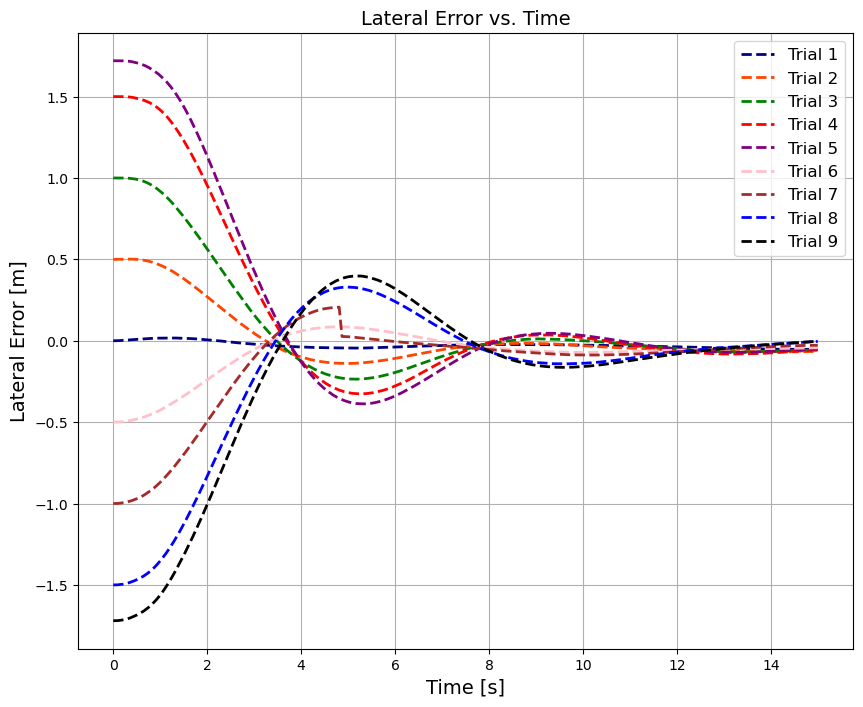

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

#plots all trials for varying initial lateral errors
axes.plot(data1['time'], data1['e_lat'], linestyle='dashed', color ='navy', linewidth=2, label="Trial 1")
axes.plot(data2['time'], data2['e_lat'], linestyle='dashed', color='orangered', linewidth=2, label="Trial 2")
axes.plot(data3['time'], data3['e_lat'], linestyle='dashed', color='green', linewidth=2, label="Trial 3")
axes.plot(data4['time'], data4['e_lat'], linestyle='dashed', color='red', linewidth=2, label="Trial 4")
axes.plot(data5['time'], data5['e_lat'], linestyle='dashed', color='purple', linewidth=2, label="Trial 5")
axes.plot(data6['time'], data6['e_lat'], linestyle='dashed', color='pink', linewidth=2, label="Trial 6")
axes.plot(data7['time'], data7['e_lat'], linestyle='dashed', color='brown', linewidth=2, label="Trial 7")
axes.plot(data8['time'], data8['e_lat'], linestyle='dashed', color='blue', linewidth=2, label="Trial 8")
axes.plot(data9['time'], data9['e_lat'], linestyle='dashed', color='black', linewidth=2, label="Trial 9")
axes.grid()
axes.tick_params(labelsize=10)
axes.set_title("Lateral Error vs. Time", fontsize=14)
axes.set_ylabel('Lateral Error [m]', fontsize=14)
axes.set_xlabel('Time [s]', fontsize=14)
axes.legend(fontsize='large')

plt.show()

The pitch angle vs. time graph illustrates how in each trial, the segbot was able to stabilize itself keeping its pitch angle around 1 degree. This makes sense because the system was originally stabilized around a moving segbot, hence the segbot should reach equilibrium around a non-zero pitch angle.

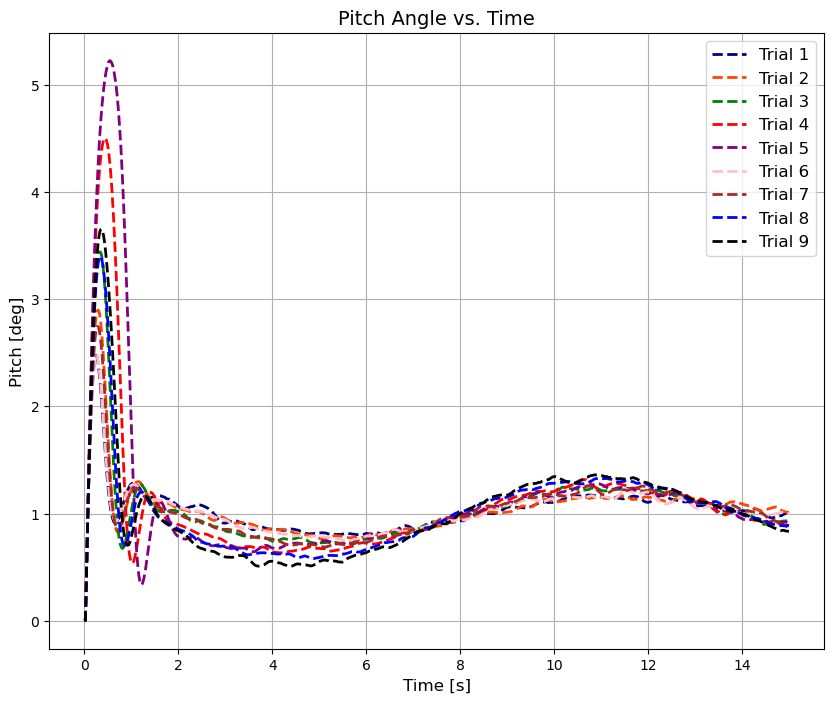

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(data1['time'], np.array(data1['theta'])*(180/np.pi), linestyle='dashed', color ='navy', linewidth=2, label="Trial 1")
axes.plot(data2['time'], np.array(data2['theta'])*(180/np.pi), linestyle='dashed', color='orangered', linewidth=2, label="Trial 2")
axes.plot(data3['time'], np.array(data3['theta'])*(180/np.pi), linestyle='dashed', color='green', linewidth=2, label="Trial 3")
axes.plot(data4['time'], np.array(data4['theta'])*(180/np.pi), linestyle='dashed', color='red', linewidth=2, label="Trial 4")
axes.plot(data5['time'], np.array(data5['theta'])*(180/np.pi), linestyle='dashed', color='purple', linewidth=2, label="Trial 5")
axes.plot(data6['time'], np.array(data6['theta'])*(180/np.pi), linestyle='dashed', color='pink', linewidth=2, label="Trial 6")
axes.plot(data7['time'], np.array(data7['theta'])*(180/np.pi), linestyle='dashed', color='brown', linewidth=2, label="Trial 7")
axes.plot(data8['time'], np.array(data8['theta'])*(180/np.pi), linestyle='dashed', color='blue', linewidth=2, label="Trial 8")
axes.plot(data9['time'], np.array(data9['theta'])*(180/np.pi), linestyle='dashed', color='black', linewidth=2, label="Trial 9")

axes.tick_params(labelsize=10)
axes.set_title("Pitch Angle vs. Time", fontsize=14)
axes.set_ylabel('Pitch [deg]', fontsize=12)
axes.set_xlabel('Time [s]', fontsize=12)
axes.legend(fontsize='large')
axes.grid()

plt.show()